## 밑바닥부터 시작하는 딥러닝(Deep Learning from Scratch) 챕터별 예제코드 정리 
예제코드가 기본이나 정확히 일치하지는 않습니다. 개인적으로 모든 코드들을 문서화하되 너무 기본적인 내용은 제외하거나 나름대로 더 필요하다고 생각되는 내용은 추가하였습니다. 같은 내용을 다른 방식으로 구현하는 경우도 있습니다.
## Chapter 4. 신경망 학습
### 4.4 Gradient descent (경사하강법)
추후에 계산그래프를 이용한 해석적 미분(analytic gradient)을 활용할 것이나 본 예제에서는 수치미분(numerical gradient)을 활용한다. gradient descent의 hyper-parameter로 learning rate(학습률) 또는 stepsize-parameter라는 것이 있으며 적절한 값을 정해주어야 gradient descent가 잘 동작한다.

In [2]:
import numpy as np
import matplotlib.pylab as plt
# numerical gradient 함수로 어떤 특정값에서의 다변수함수의 gradient를 계산
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val
    return grad

In [3]:
## gradient descent (경사하강법)
# init_x : 초기 x 값, lr : learning rate (학습률), step_num : iteration 횟수
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
    x = init_x.copy()
    x_history = []
    for i in range(step_num):
        x_history.append(x.copy())
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x, np.array(x_history)

### example 1
gradient descent의 예제로서는 아래와 같은 함수를 활용한다. 최소값은 (0,0)일 때이다.  

$$f(x_0,x_1)={x_0}^2+{x_1}^2$$

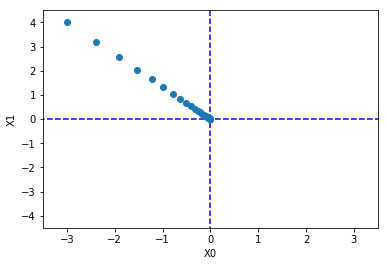

In [5]:
# example1
def function_2(x):
        return np.sum(x**2)

init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x = init_x, lr = 0.1, step_num = 100)

# example1 visualize
plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')
plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [9]:
# gradient descent or gradient ascent는 hyper-parameter인 학습률을 적절히 설정하는 것이 매우 중요
# 학습률이 너무 클 경우 (학습률이 너무커서 발산한 것을 볼 수 있다.)
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x = init_x, lr = 100, step_num = 100)
print(x)

# 학습률이 너무 작을 경우 (gradient descent로 최적점까지 찾아가지못하였다.)
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x = init_x, lr = 1e-10, step_num = 100)
print(x)

[ -2.67498081e+14  -1.25119902e+12]
[-2.99999994  3.99999992]


### example 2
hidden layer가 없고 2차원의 input을 받아 3차원의 output을 내놓는 단순한 network를 예제로 활용한다. 3차원의 output은 각 범주에 속할 확률값이다. 해당 예제를 구현하기위해 먼저 score값을 확률로 변환해주는 softmax layer와 classification 문제이므로 cross entropy loss를 구현한다.

In [11]:
# prerequisite
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c) # overflow의 보정
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta)) # delta는 y가 0값이 될 경우에 값이 계산안되는 경우를 보정한 것

위의 경우 가중치가 3 x 2의 행렬이 될 것이므로 numerical gradient도 행렬의 꼴을 반영할 수 있도록 변형한다.

In [12]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    for idx1 in range(x.shape[0]):
        for idx2 in range(x.shape[1]):
            tmp_val = x[idx1, idx2]
            x[idx1, idx2] = tmp_val + h
            fxh1 = f(x)

            x[idx1, idx2] = tmp_val - h
            fxh2 = f(x)

            grad[idx1, idx2] = (fxh1 - fxh2) / (2 * h)
            x[idx1, idx2] = tmp_val
    return grad

위의 예제를 생성하는 class를 정의한다.

In [13]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(3,2)

    def predict(self, x):
        if x.ndim == 1:
            x = x.reshape(2,1)
            return softmax(np.dot(self.W, x))
        else:
            return softmax(np.dot(self.W, x))

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        if t.ndim == 1:
            t = t.reshape(3,1)
            loss = cross_entropy_error(y, t)
            return loss
        else:
            loss = cross_entropy_error(y, t)
            return loss

아래의 코드에서 np.array의 index 기준 1의 확률값이 높게 나왔으므로 true label의 설정에 따라 loss가 알맞게 계산됨을 확인할 수 있다.

In [18]:
# forward가 올바른 결과인지 확인하기
net = simpleNet()
x = np.array([.6, .9])
print(net.predict(x), net.loss(x, t = np.array([0,0,1])))
print(net.predict(x), net.loss(x, t = np.array([0,1,0]))) # true label로 예측할 확률이 가장 컸을 경우 loss가 작음

[[ 0.1855394 ]
 [ 0.5950234 ]
 [ 0.21943721]] 1.23037527595
[[ 0.1855394 ]
 [ 0.5950234 ]
 [ 0.21943721]] 0.854789193123


위의 경우 예제에서 true label을 (0,1,0)으로 했을 때 위의 경우와 같은 x에 대해서 gradient를 아래의 코드로 계산할 수 있다.

In [19]:
x = np.array([.6, .9])
t = np.array([0, 1, 0])
def f(W):
    return net.loss(x, t)
numerical_gradient(f, net.W)

array([[ 0.05653467,  0.084802  ],
       [-0.12468032, -0.18702048],
       [ 0.06814565,  0.10221848]])